## Análisis de Datos

### Librerías

In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gdown
import os
import sys
import pickle
from typing import Tuple, Dict, Union
from pathlib import Path

sys.path.append(os.path.abspath('../'))

### Datos

In [ ]:
gdown.download(id='1KnpxHgw0xS6tny5VkT6c8w8TmPYKFHVK', output='dataset.zip', quiet=False)
!unzip dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KnpxHgw0xS6tny5VkT6c8w8TmPYKFHVK
From (redirected): https://drive.google.com/uc?id=1KnpxHgw0xS6tny5VkT6c8w8TmPYKFHVK&confirm=t&uuid=7fbbaa38-f000-433a-a834-45804d99eeb4
To: /content/dataset.zip
100%|██████████| 155M/155M [00:03<00:00, 41.5MB/s]


Archive:  dataset.zip
  inflating: artists_reduced.csv     
  inflating: bgg_data_documentation.txt  
  inflating: designers_reduced.csv   
  inflating: games.csv               
  inflating: mechanics.csv           
  inflating: publishers_reduced.csv  
  inflating: ratings_distribution.csv  
  inflating: subcategories.csv       
  inflating: themes.csv              
  inflating: user_ratings.csv        


In [ ]:
df_user_ratings = pd.read_csv('user_ratings.csv')
df_user_ratings.columns = ['item', 'rating', 'user']
df_user_ratings = df_user_ratings.rename(columns={'BGGId': 'item', 'Rating': 'rating', 'Username': 'user'})

In [ ]:
def split_train_test(
    data: pd.DataFrame, test_size: float
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    data_grouped_by_user = data.groupby("user")
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (nm, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype="bool")
            idx[
                np.random.choice(
                    n_items_u, size=int(test_size * n_items_u), replace=False
                ).astype("int64")
            ] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            #print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te


def numerize(tp: pd.DataFrame, user2id: Dict, item2id: Dict) -> pd.DataFrame:
    user = [user2id[x] for x in tp["user"]]
    item = [item2id[x] for x in tp["item"]]
    return pd.DataFrame(data={"user": user, "item": item}, columns=["user", "item"])

In [ ]:
# se dividirá en 3 partes, training, testing y validation
# para eso se utilizará el 60& para train, 20% para test y 20% val

data_tr_val, data_te = split_train_test(df_user_ratings, test_size=0.2)
data_tr, data_val = split_train_test(data_tr_val, test_size=0.2)

print(f'El conjunto de entrenamiento tiene {len(data_te)} datos, el de testeo tiene {len(data_tr)} datos y el de validación tiene {len(data_val)} datos.')

KeyboardInterrupt: 

Lo anterior se demoró cerca de 8 min, por lo que se guardaron los conjuntos en archivos .csv

In [ ]:
data_tr.to_csv('training_ratings.csv', index=False)
data_te.to_csv('testing_ratings.csv', index=False)
data_val.to_csv('validation_ratings.csv', index=False)

Ejecutar desde acá para ahorrarse esos 8 minutos.

In [ ]:
gdown.download(id='1H_24ycns6zbOVfHFJRI9vGjVffVA5z6v', output='training_ratings.csv', quiet=False)
gdown.download(id='1Jc0AzcH_XHLkBDWuF0NloTlpLV0PrwOJ', output='testing_ratings.csv', quiet=False)
gdown.download(id='1pKmf07ehHOmlvIyT8nv__vPuWE2Z3ygZ', output='validation_ratings.csv', quiet=False)

data_tr = pd.read_csv('training_ratings.csv')
data_te = pd.read_csv('testing_ratings.csv')
data_val = pd.read_csv('validation_ratings.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1H_24ycns6zbOVfHFJRI9vGjVffVA5z6v
From (redirected): https://drive.google.com/uc?id=1H_24ycns6zbOVfHFJRI9vGjVffVA5z6v&confirm=t&uuid=8ea6d741-966b-4065-96ef-04addbb7d4bc
To: /content/training_ratings.csv
100%|██████████| 249M/249M [00:01<00:00, 229MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Jc0AzcH_XHLkBDWuF0NloTlpLV0PrwOJ
To: /content/testing_ratings.csv
100%|██████████| 73.0M/73.0M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pKmf07ehHOmlvIyT8nv__vPuWE2Z3ygZ
To: /content/validation_ratings.csv
100%|██████████| 58.3M/58.3M [00:00<00:00, 259MB/s]


In [ ]:
# Seleccionamos las observaciones del set de entrenamiento
tr_items = pd.unique(data_tr["item"])
tr_users = pd.unique(data_tr["user"])

# Guardamos los índices por temas de formato posterior
item2id = dict((sid, i) for (i, sid) in enumerate(tr_items))
user2id = dict((pid, i) for (i, pid) in enumerate(tr_users))

tr_num = numerize(data_tr, user2id, item2id)
te_num = numerize(data_te, user2id, item2id)
val_num = numerize(data_val, user2id, item2id)


### Preprocesamiento de Datos

In [ ]:
r_train = len(data_tr)
r_val = len(data_val)
full_data = pd.concat([data_tr, data_val], ignore_index=True)
full_data.head()

,item,rating,user
0,112092,9.0,Fu_Koios
1,223033,9.0,Fu_Koios
2,9209,7.0,beastvol
3,13,8.0,beastvol
4,3076,9.0,beastvol


En primer lugar, analizamos los datos nulos.

In [ ]:
full_data[full_data.isnull().any(axis=1)]

,item,rating,user


Como podemos ver, no hay filas con valores NaN.

En segundo lugar, analizamos las filas duplicadas

In [ ]:
data_tr.drop_duplicates(inplace=True, subset=['user', 'item'])
data_val.drop_duplicates(inplace=True, subset=['user', 'item'])

Notamos que un 2.37% y un 0.79% de los datos corresponden a filas duplicadas para Train y Validation respectivamente, por lo tanto, las eliminamos.

<font face="Georgia" size=4 color=red>

IMPORTANTE: Se cambió la forma en que se eliminaban los duplicados, esto debido a que anteriormente, el conjunto de validación no quedaba con la misma cantidad de usuarios que el conjunto de train. Lo que trajo algunos problemas en la utilización de algunos modelos. </font>

In [ ]:
print(f"Número de reviews de train antes y después de preprocesar {r_train}/{len(data_tr)}")
print(f"Número de reviews de validation antes y después de preprocesar {r_val}/{len(data_val)}")
print(f"Porcentaje de filas eliminadas en train {round((r_train-len(data_tr))/len(data_tr)*100,2)}%")
print(f"Porcentaje de filas eliminadas en validation {round((r_val-len(data_val))/len(data_val)*100,2)}%")

Número de reviews de train antes y después de preprocesar 12404267/12390406
Número de reviews de validation antes y después de preprocesar 2902587/2901744
Porcentaje de filas eliminadas en train 0.11%
Porcentaje de filas eliminadas en validation 0.03%


Esto nos deja con una proporción similar a la inicial (75-25).

### Distribución de los Datos

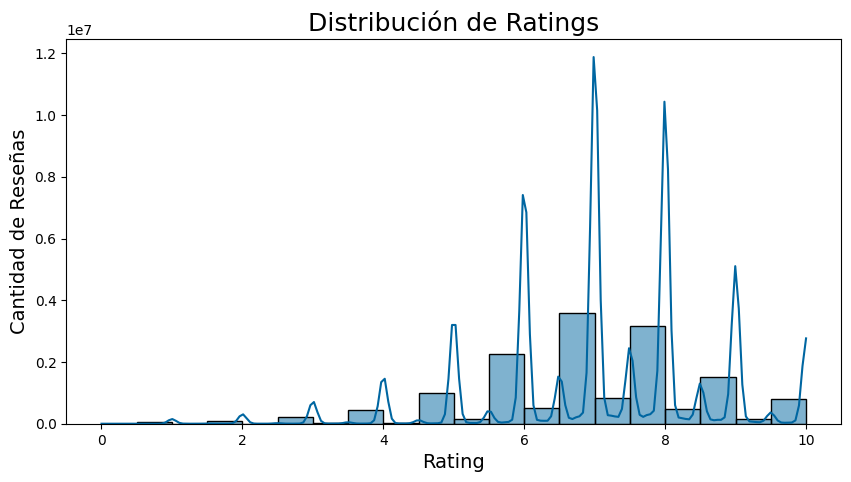

In [ ]:
# Paleta de colores
plt.figure(figsize=(10, 5))
sns.histplot(data=full_data, x='rating', bins=20, kde=True, color="#0066A1")
plt.title('Distribución de Ratings', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Cantidad de Reseñas', fontsize=14)
plt.show()

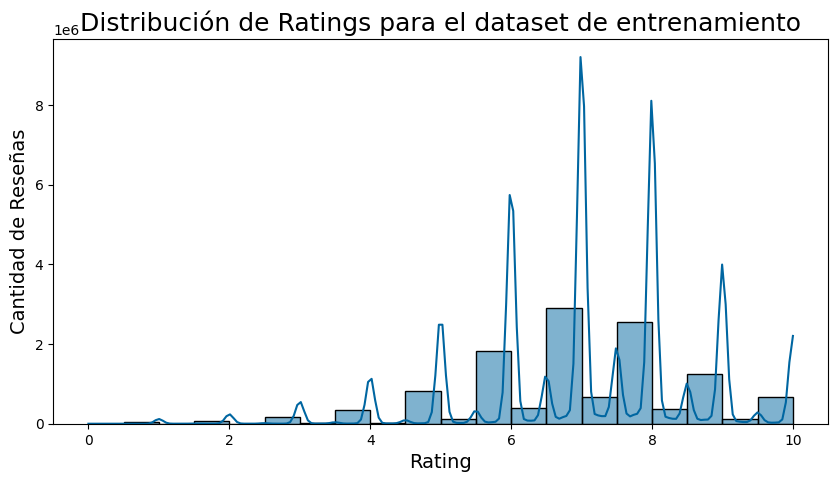

In [ ]:
# Paleta de colores
plt.figure(figsize=(10, 5))
sns.histplot(data=data_tr, x='rating', bins=20, kde=True, color="#0066A1")
plt.title('Distribución de Ratings para el dataset de entrenamiento', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Cantidad de Reseñas', fontsize=14)
plt.show()

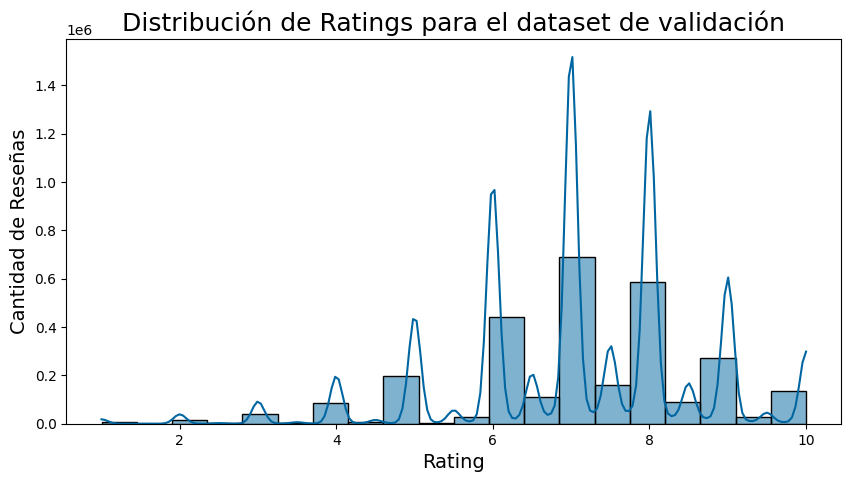

In [ ]:
# Paleta de colores
plt.figure(figsize=(10, 5))
sns.histplot(data=data_val, x='rating', bins=20, kde=True, color="#0066A1")
sns.set(style="darkgrid")
plt.title('Distribución de Ratings para el dataset de validación', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Cantidad de Reseñas', fontsize=14)
plt.show()

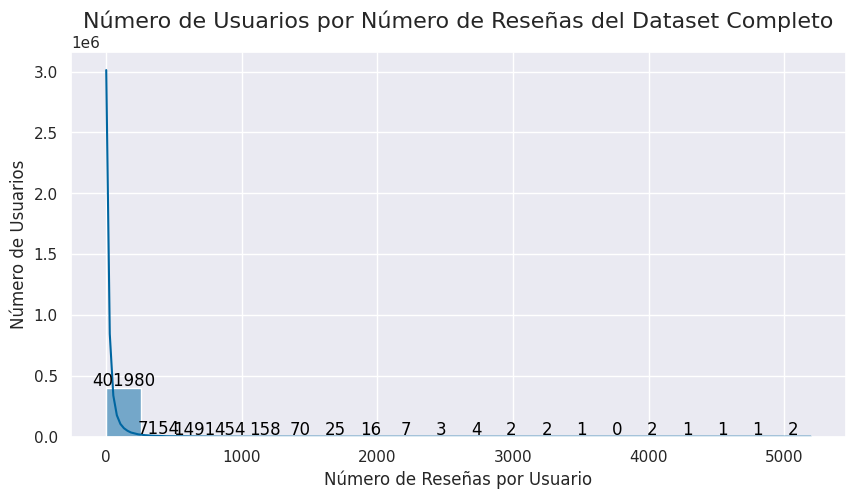

In [ ]:
user_review_counts = full_data.groupby('user').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=user_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Número de Usuarios por Número de Reseñas del Dataset Completo', fontsize=16)
plt.xlabel('Número de Reseñas por Usuario', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.show()

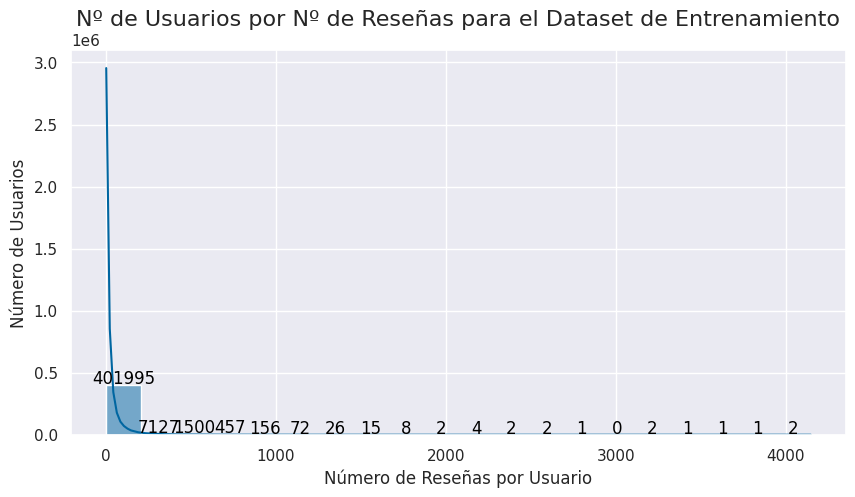

In [ ]:
user_review_counts = data_tr.groupby('user').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=user_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Usuarios por Nº de Reseñas para el Dataset de Entrenamiento', fontsize=16)
plt.xlabel('Número de Reseñas por Usuario', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.show()

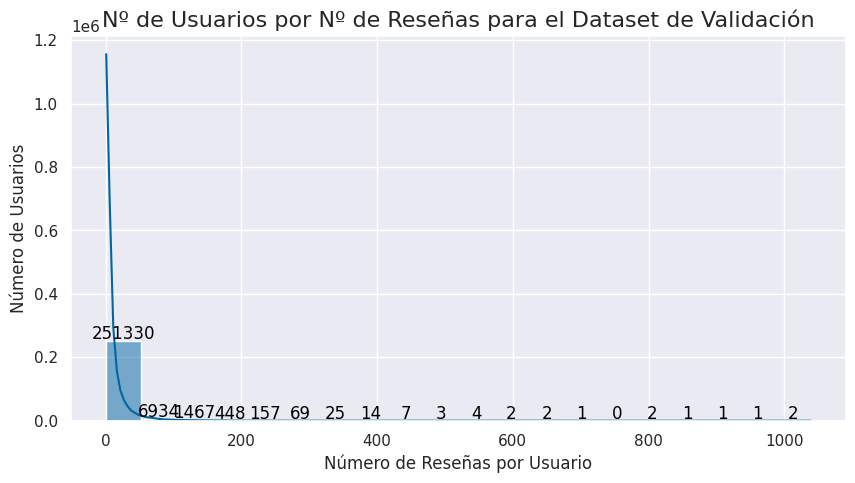

In [ ]:
user_review_counts = data_val.groupby('user').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=user_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Usuarios por Nº de Reseñas para el Dataset de Validación', fontsize=16)
plt.xlabel('Número de Reseñas por Usuario', fontsize=12)
plt.ylabel('Número de Usuarios', fontsize=12)
plt.show()

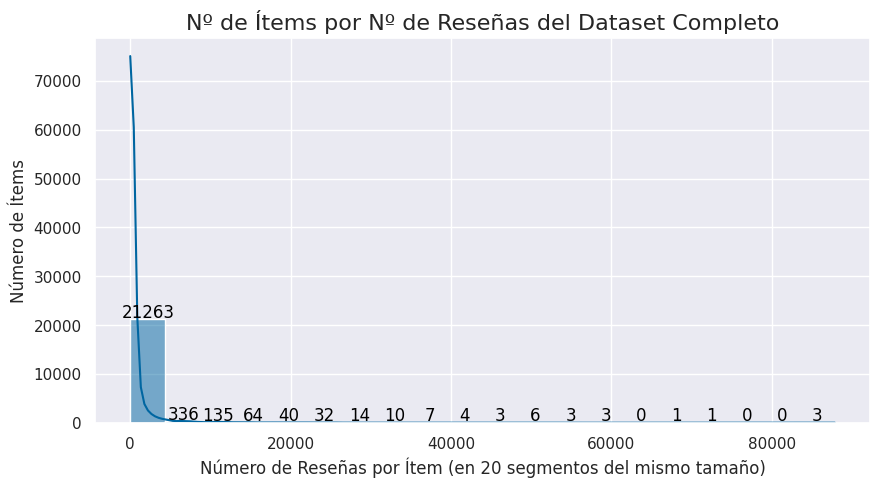

In [ ]:
item_review_counts = full_data.groupby('item').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=item_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Ítems por Nº de Reseñas del Dataset Completo', fontsize=16)
plt.xlabel('Número de Reseñas por Ítem (en 20 segmentos del mismo tamaño)', fontsize=12)
plt.ylabel('Número de Ítems', fontsize=12)
plt.show()

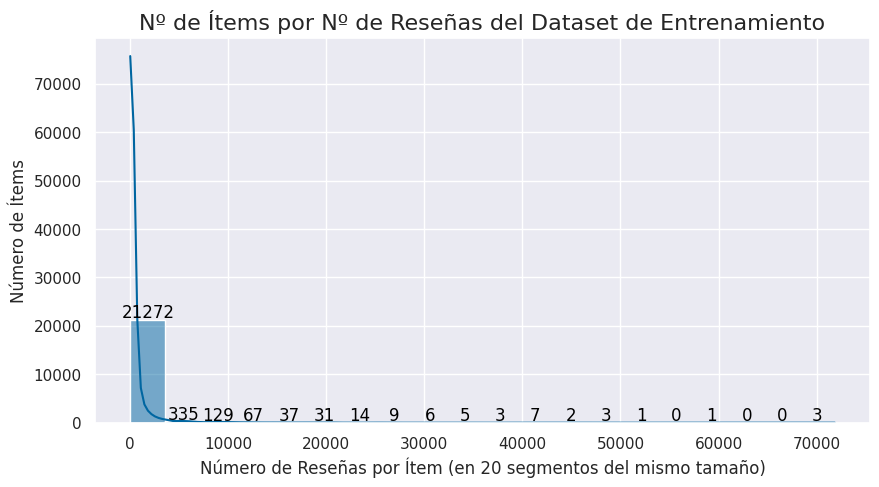

In [ ]:
item_review_counts = data_tr.groupby('item').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=item_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Ítems por Nº de Reseñas del Dataset de Entrenamiento', fontsize=16)
plt.xlabel('Número de Reseñas por Ítem (en 20 segmentos del mismo tamaño)', fontsize=12)
plt.ylabel('Número de Ítems', fontsize=12)
plt.show()

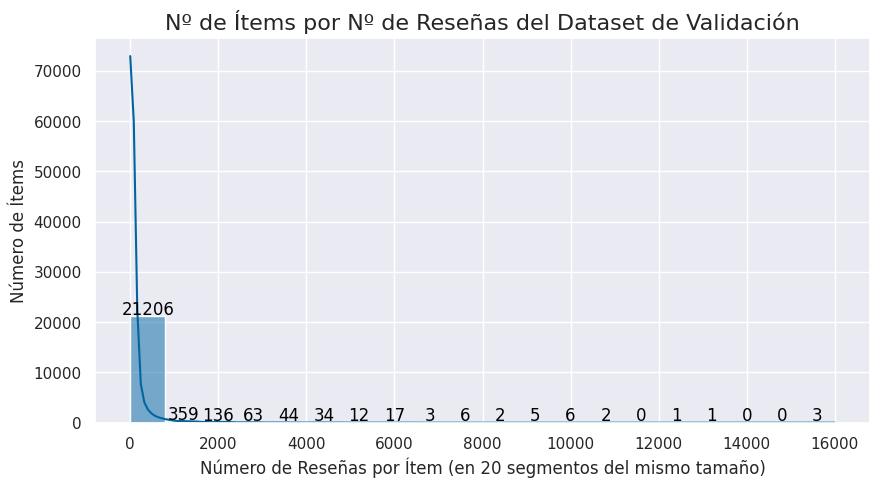

In [ ]:
item_review_counts = data_val.groupby('item').size()

plt.figure(figsize=(10, 5))
ax = sns.histplot(x=item_review_counts, bins=20, kde=True, color="#0066A1")

# Agregar el número de reseñas sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Nº de Ítems por Nº de Reseñas del Dataset de Validación', fontsize=16)
plt.xlabel('Número de Reseñas por Ítem (en 20 segmentos del mismo tamaño)', fontsize=12)
plt.ylabel('Número de Ítems', fontsize=12)
plt.show()

### Densidad del Dataset

In [ ]:
# Función para calcular las estadísticas
def calculate_statistics(data):
    num_users = data['user'].nunique()  # Número de usuarios
    num_items = data['item'].nunique()  # Número de ítems
    total_ratings = len(data)  # Total de reseñas
    avg_ratings_per_user = total_ratings / num_users  # Promedio de reseñas por usuario
    avg_ratings_per_item = total_ratings / num_items  # Promedio de reseñas por ítem
    avg_rating = data['rating'].mean()  # Promedio de rating
    rating_std = data['rating'].std()  # Desviación estándar del rating
    max_ratings_by_user = data['user'].value_counts().max()  # Máximo número de reseñas por usuario
    max_ratings_for_item = data['item'].value_counts().max() # Máximo número de reseñas por ítem
    min_ratings_by_user = data['user'].value_counts().min()  # Mínimo número de reseñas por usuario
    min_ratings_for_item = data['item'].value_counts().min() # Mínimo número de reseñas por ítem
    density = (total_ratings / (num_users * num_items)) * 100  # Densidad en porcentaje

    return {
        'Número de Usuarios': num_users,
        'Número de Ítems': num_items,
        'Total de Reseñas': total_ratings,
        'Promedio de Reseñas por Usuario': avg_ratings_per_user,
        'Promedio de Reseñas por Ítem': avg_ratings_per_item,
        'Promedio de Rating': avg_rating,
        'Desviación Estándar del Rating': rating_std,
        'Máximo Número de Reseñas por un Usuario': max_ratings_by_user,
        'Máximo Número de Reseñas para un Ítem': max_ratings_for_item,
        'Mínimo Número de Reseñas por un Usuario': min_ratings_by_user,
        'Mínimo Número de Reseñas para un Ítem': min_ratings_for_item,
        'Densidad (%)': density
    }

train_stats = calculate_statistics(data_tr)
validation_stats = calculate_statistics(data_val)
full_data_stats = calculate_statistics(full_data)

# Crear DataFrame con las estadísticas
statistics = pd.DataFrame({
    'Estadística': [
        'Número de Usuarios',
        'Número de Ítems',
        'Total de Reseñas',
        'Promedio de Reseñas por Usuario',
        'Promedio de Reseñas por Ítem',
        'Promedio de Rating',
        'Desviación Estándar del Rating',
        'Máximo Número de Reseñas por un Usuario',
        'Máximo Número de Reseñas para un Ítem',
        'Mínimo Número de Reseñas por un Usuario',
        'Mínimo Número de Reseñas para un Ítem',
        'Densidad (%)'
    ],
    'Full Dataset': [
        full_data_stats['Número de Usuarios'],
        full_data_stats['Número de Ítems'],
        full_data_stats['Total de Reseñas'],
        full_data_stats['Promedio de Reseñas por Usuario'],
        full_data_stats['Promedio de Reseñas por Ítem'],
        full_data_stats['Promedio de Rating'],
        full_data_stats['Desviación Estándar del Rating'],
        full_data_stats['Máximo Número de Reseñas por un Usuario'],
        full_data_stats['Máximo Número de Reseñas para un Ítem'],
        full_data_stats['Mínimo Número de Reseñas por un Usuario'],
        full_data_stats['Mínimo Número de Reseñas para un Ítem'],
        full_data_stats['Densidad (%)']
    ],
    'Train': [
        train_stats['Número de Usuarios'],
        train_stats['Número de Ítems'],
        train_stats['Total de Reseñas'],
        train_stats['Promedio de Reseñas por Usuario'],
        train_stats['Promedio de Reseñas por Ítem'],
        train_stats['Promedio de Rating'],
        train_stats['Desviación Estándar del Rating'],
        train_stats['Máximo Número de Reseñas por un Usuario'],
        train_stats['Máximo Número de Reseñas para un Ítem'],
        train_stats['Mínimo Número de Reseñas por un Usuario'],
        train_stats['Mínimo Número de Reseñas para un Ítem'],
        train_stats['Densidad (%)']
    ],
    'Validation': [
        validation_stats['Número de Usuarios'],
        validation_stats['Número de Ítems'],
        validation_stats['Total de Reseñas'],
        validation_stats['Promedio de Reseñas por Usuario'],
        validation_stats['Promedio de Reseñas por Ítem'],
        validation_stats['Promedio de Rating'],
        validation_stats['Desviación Estándar del Rating'],
        validation_stats['Máximo Número de Reseñas por un Usuario'],
        validation_stats['Máximo Número de Reseñas para un Ítem'],
        validation_stats['Mínimo Número de Reseñas por un Usuario'],
        validation_stats['Mínimo Número de Reseñas para un Ítem'],
        validation_stats['Densidad (%)']
    ]
})

# Exportar la tabla a un archivo excel
statistics.round(2).to_excel('estadisticas_dataset.xlsx', index=False)

# Mostrar tabla
statistics.round(2)

,Estadística,Full Dataset,Train,Validation
0,Número de Usuarios,411374.00,411374.00,260470.00
1,Número de Ítems,21925.00,21925.00,21900.00
2,Total de Reseñas,15306854.00,12390406.00,2901744.00
3,Promedio de Reseñas por Usuario,37.21,30.12,11.14
4,Promedio de Reseñas por Ítem,698.15,565.13,132.50
5,Promedio de Rating,7.14,7.15,7.10
6,Desviación Estándar del Rating,1.55,1.55,1.53
7,Máximo Número de Reseñas por un Usuario,5195.00,4147.00,1039.00
8,Máximo Número de Reseñas para un Ítem,87843.00,71852.00,15998.00
9,Mínimo Número de Reseñas por un Usuario,1.00,1.00,1.00


Más adelante podría ser importante analizar items que tengan muchas calificaciones o usuarios que hayan hecho muchas calificaciones. Esto ya que nos interesa hacer recomendaciones grupales y necesitamos un ground truth. Sería importante agrupar usuarios que probablemente hayan calificado al mismo juego (porque han calificado mucho y encontraremos un juego en común) o seleccionar items que se hayan calificado mucho (encontraremos usuarios en común).

In [ ]:
# Contar cuántas calificaciones tiene cada ítem
top_items = (
    df_user_ratings.groupby("item")
    .size()
    .reset_index(name="num_ratings")
    .sort_values("num_ratings", ascending=False)
    .head(20)
)

top_items


,item,num_ratings
7919,30549,107760
673,822,107601
12,13,106725
9861,68448,89014
8459,36218,80901
4702,9209,75352
14811,178900,73188
14059,167791,72753
14450,173346,68063
7975,31260,65637


In [ ]:
# Contar cuántas calificaciones tiene cada usuario
top_users = (
    df_user_ratings.groupby("user")
    .size()
    .reset_index(name="num_ratings")
    .sort_values("num_ratings", ascending=False)
    .head(20)
)

top_users


,user,num_ratings
345867,oldgoat3769967,6493
401544,warta,6247
316289,leffe dubbel,6047
195226,TomVasel,5706
50189,Doel,5226
80685,Hessu68,5036
205105,Walt Mulder,4887
270360,fake,4275
195046,Tolkana,4078
134530,Nap16,3974
